# Amino Acid Analysis

Notebook with code to replicate the analysis of amino acid data.

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.stats import wilcoxon

## Import Data

In [13]:
data = pd.read_csv("/content/amino_acid_data.csv")
data = data.fillna(0)

## Define Funcitions

In [5]:
def get_vector(row,n:int) -> np.array:
  """Converts each row the data set into a vector representing the normalized
  amino acid composition of the corresponding sample.

  Ags:
    row: row of the data set.
    n: number of amino acids in the sample to be analyzed.

  Returns:
    numpy array representing the normalized amino acid composition of the
    corresponding sample.
  """
  if n == 6:
    cols = ['Gly', 'D&L-Ser', 'D&L-Ala', 'D&L-Asp', 'D&L-Glu', 'D&L-valine']
    return np.array([row[col] if col in row.index else 0 for col in cols])
  if n == 5:
    return np.array([row['Gly'], row['D&L-Ser'], row['D&L-Ala'], row['D&L-Asp'],
          row['D&L-valine']])
  if n == 4:
    return np.array([row['Gly'], row['D&L-Ser'], row['D&L-Ala'],
                     row['D&L-valine']])
  if n == 3:
    return np.array([row['Gly'], row['D&L-Ser'], row['D&L-Ala']])

def get_distance_matrix(X:np.array) -> np.array:
  """Generates an array containing the squared eculidean distance between each
  row in a matrix.
  """
  X1 = X[:, np.newaxis, :]
  X2 = X[np.newaxis, :, :]
  distances = np.sum((X1 - X2) ** 2, axis=2)
  return distances


def objective(alpha:np.array,distance_matrix:np.array) -> np.array:
  """Objective function for the optimal alpha value used in each anomalousness
  calculation.
  """
  mins = [np.min(d[d != 0]) for d in distance_matrix]
  avg_D = np.mean(mins)
  min_D = np.min(mins)
  sigma = -np.log(min_D / avg_D)/(avg_D**2 - min_D**2)
  sigma_sq_inv = 1 /(sigma**2)
  alpha_outer = np.outer(alpha,alpha)
  return np.sum(alpha_outer*np.exp(-distance_matrix * sigma_sq_inv))


def constraint(alpha:np.array):
  """Constraint used in the optimization process to findthe optimal alpha value
  used in each anomalousness calculation."""
  return np.sum(alpha)-1


def get_anoms(alpha:np.array,distance_matrix:np.array) -> np.array:
  """
  Returns an array containing the anomalousness of each sample in the set.

  Args:
    alpha: vector of alpha values obtained via optimization.
    distance_matrix: array containing the squared eculidean distance between
    the maximum intensity vectors for each sample.

  Returns:
    array containing the anomalousness of each sample in the set.
  """
  sigma = np.median(distance_matrix)
  sigma_sq_inv = 1 /(sigma**2)
  term1 = alpha*(-distance_matrix * sigma_sq_inv)
  alpha_outer = np.outer(alpha,alpha)
  term2 = alpha_outer*np.exp(-distance_matrix * sigma_sq_inv)
  return np.sum(1 - 2*term1 + term2,axis=1)


def ordinal_ranking(arr):
    """Return the ordinal ranking of each value in an array."""
    sorted_arr = sorted(set(arr))
    rank_map = {value: rank + 1 for rank, value in enumerate(sorted_arr)}
    return [(len(arr)+1)-rank_map[num] for num in arr]


def percentile_of_first(lst):
    """Return the percentile of the first element in a list."""
    if len(lst) < 2:
        raise ValueError("List must have at least two elements.")

    first = lst[0]
    rest = lst[1:]

    count = sum(x <= first for x in rest)
    percentile = (count / len(rest)) * 100

    return percentile

## Run Anomalousness Analysis and Significance Tests

In [30]:
results = []
for n in tqdm([6,5,4,3]): #Loop through number of amino acids in full and
                          #truncated data set.
  results_for_n_amino_acids = {}
  results_for_n_amino_acids["Number of Amino Acids"] = n

  #Convert abiotic data into matrix.
  abiotic_data = np.array([get_vector(row,n) for i,row in
                           data.iterrows() if row['Type'] == 'AP'])

  AC_Low_anom_data = []
  for i,row in data.iterrows(): #Loop through all rows of the data.
    if row['Type'] == 'AC_Low': #Pick out all samples on AC_Low data.
      AC_Low_data = get_vector(row,n) #Represent sample as vector.
      all_data = np.vstack((AC_Low_data,abiotic_data)) #Append vector to abiotic
                                                       #data.
      D = get_distance_matrix(all_data) #Generate distance matrix.
      D = D / np.max(D) #Normalize distance matrix.

      #Find optimal alphas
      b = (0,1)
      bnds = [b for i in range(len(all_data))]
      con1 = {'type': 'eq', 'fun': constraint}
      cons = [con1]
      alpha0=np.zeros(len(all_data))
      solution = minimize(objective,alpha0,method='SLSQP',bounds=bnds,
                          args=(D),constraints=cons)
      alpha = solution.x

      #Calculate anomalousness of each sample in the set.
      anoms = get_anoms(alpha,D)

      #Append results.
      AC_Low_anom_data.append({"AC_Low Sample": row['Sample '],
                  "Anomalousness Ranking for AC_Low Sample":
                    ordinal_ranking(anoms)[0],
                  "Anomalousness of AC_Low Sample": anoms[0],
                  "Median Anomalousness of AP Samples": np.median(anoms[1:]),
        "Anomalousness Percentile of AC_Low Sample": percentile_of_first(anoms)
                  })

  #Save results of anomalousness analysis and significance test.
  results_df = pd.DataFrame(AC_Low_anom_data)
  results_df.to_csv(f'AC_Low_anomalousness_results_{str(n)}_amino.csv')

  stat, p_value = wilcoxon([p - 50 for p in
                      results_df['Anomalousness Percentile of AC_Low Sample']])

  results_for_n_amino_acids["Wilcoxon statistic for AC_Low"] = stat
  results_for_n_amino_acids["p-value for AC_Low"] = p_value


  #Convert abiotic data into matrix again (same procedure as above).
  abiotic_data = [get_vector(row,n) for i,row in data.iterrows() if
                  row['Type'] == 'AP']

  AC_High_anom_data = []
  for i,row in data.iterrows():  #Loop through all rows of the data.
    if row['Type'] == 'AC_High':  #Pick out all samples in AC_High data.
      AC_High_data = get_vector(row,n) #Represent sample as vector.
      all_data = np.vstack((AC_High_data,abiotic_data))#Append vector to abiotic
                                                        #data.
      D = get_distance_matrix(all_data) #Generate distance matrix.

      #Find optimal alphas (same optimization problem as above).
      b = (0,1)
      bnds = [b for i in range(len(all_data))]
      con1 = {'type': 'eq', 'fun': constraint}
      cons = [con1]
      alpha0=np.zeros(len(all_data))
      solution = minimize(objective,alpha0,method='SLSQP',bounds=bnds,
                          args=(D),constraints=cons)
      alpha = solution.x

      #Calculate anomalousness of each sample in the set.
      anoms = get_anoms(alpha,D)

      #Append results.
      AC_High_anom_data.append({"AC_High Sample": row['Sample '],
                  "Anomalousness Ranking for AC_High Sample":
                    ordinal_ranking(anoms)[0],
                  "Anomalousness of AC_High Sample": anoms[0],
                  "Median Anomalousness of AP Samples": np.median(anoms[1:]),
        "Anomalousness Percentile of AC_High Sample": percentile_of_first(anoms)
                  })

  #Save results of anomalousness analysis and significance test.
  results_df = pd.DataFrame(AC_High_anom_data)
  results_df.to_csv(f'AC_High_anomalousness_results_{str(n)}_amino.csv')

  stat, p_value = wilcoxon([p - 50 for p in
                      results_df['Anomalousness Percentile of AC_High Sample']])

  results_for_n_amino_acids["Wilcoxon statistic for AC_High"] = stat
  results_for_n_amino_acids["p-value for AC_High"] = p_value


  #Convert abiotic data into matrix again.
  abiotic_data = [get_vector(row,n) for i,row in
                  data.iterrows() if row['Type'] == 'AP']

  b_anom_data = []
  for i,row in data.iterrows():  #Loop through all rows of the data.
    if row['Type'] == 'B':  #Pick out all biotic samples.
      b_data = get_vector(row,n) #Represent sample as vector.
      all_data = np.vstack((b_data,abiotic_data))#Append vector to abiotic data.
      D = get_distance_matrix(all_data) #Generate distance matrix.

      #Find optimal alphas (same SLSQP optimization).
      b = (0,1)
      bnds = [b for i in range(len(all_data))]
      con1 = {'type': 'eq', 'fun': constraint}
      cons = [con1]
      alpha0=np.zeros(len(all_data))
      solution = minimize(objective,alpha0,method='SLSQP',bounds=bnds,
                          args=(D),constraints=cons)
      alpha = solution.x

      #Calculate anomalousness of each sample in the set.
      anoms = get_anoms(alpha,D)

      #Append results.
      b_anom_data.append({"Biotic Sample": row['Sample Type'],
                  "Anomalousness Ranking for Biotic Sample":
                  ordinal_ranking(anoms)[0],
                  "Anomalousness of Biotic Sample": anoms[0],
                  "Median Anomalousness of AP Samples": np.median(anoms[1:]),
         "Anomalousness Percentile of Biotic Sample": percentile_of_first(anoms)
                  })

  #Save results.
  results_df = pd.DataFrame(b_anom_data)
  results_df.to_csv(f'Biotic_anomalousness_results_{str(n)}_amino.csv')

  stat, p_value = wilcoxon([p - 50 for p in
                      results_df['Anomalousness Percentile of Biotic Sample']])

  results_for_n_amino_acids["Wilcoxon statistic for Biotic"] = stat
  results_for_n_amino_acids["p-value for Biotic"] = p_value

  results.append(results_for_n_amino_acids)

print(results)


100%|██████████| 4/4 [00:49<00:00, 12.47s/it]

[{'Number of Amino Acids': 6, 'Wilcoxon statistic for AC_Low': np.float64(2.0), 'p-value for AC_Low': np.float64(0.01171875), 'Wilcoxon statistic for AC_High': np.float64(21.0), 'p-value for AC_High': np.float64(8.147144204022495e-12), 'Wilcoxon statistic for Biotic': np.float64(8.0), 'p-value for Biotic': np.float64(8.240698574691872e-27)}, {'Number of Amino Acids': 5, 'Wilcoxon statistic for AC_Low': np.float64(4.0), 'p-value for AC_Low': np.float64(0.02734375), 'Wilcoxon statistic for AC_High': np.float64(112.5), 'p-value for AC_High': np.float64(5.221058335778723e-10), 'Wilcoxon statistic for Biotic': np.float64(18.5), 'p-value for Biotic': np.float64(6.641816699790889e-27)}, {'Number of Amino Acids': 4, 'Wilcoxon statistic for AC_Low': np.float64(3.0), 'p-value for AC_Low': np.float64(0.01953125), 'Wilcoxon statistic for AC_High': np.float64(104.0), 'p-value for AC_High': np.float64(3.5476779619297607e-10), 'Wilcoxon statistic for Biotic': np.float64(19.0), 'p-value for Biotic': n

## Generate Figure 1

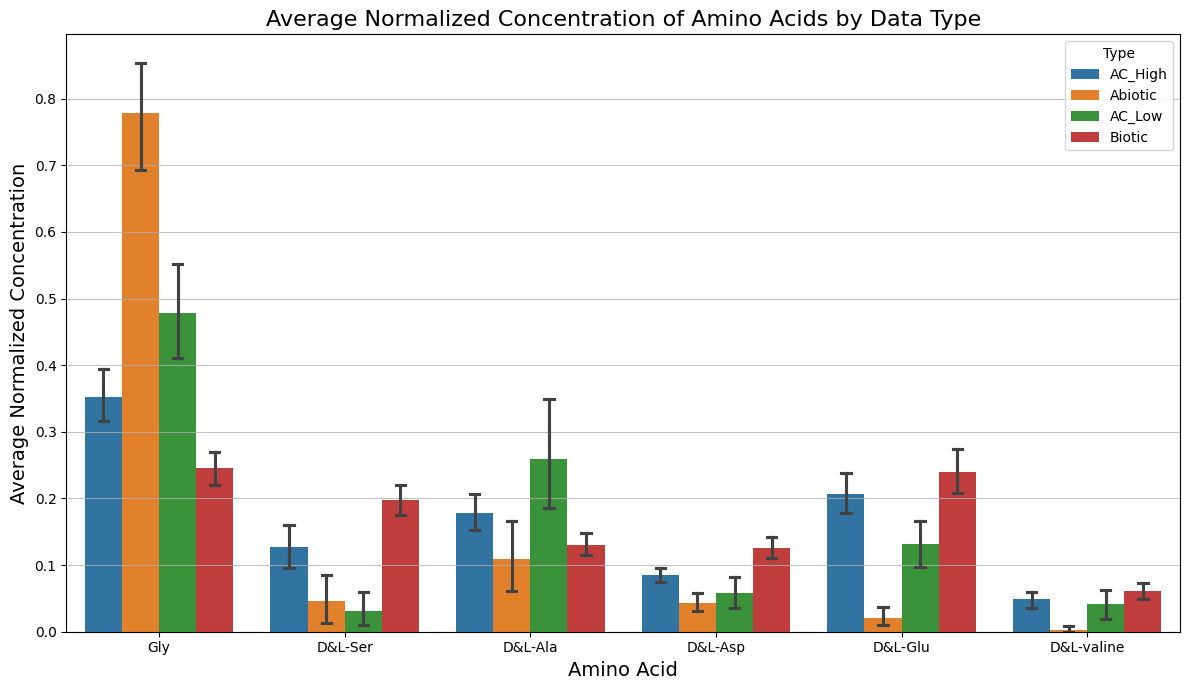

In [31]:
component_names = ['Gly', 'D&L-Ser', 'D&L-Ala', 'D&L-Asp', 'D&L-Glu',
'D&L-valine']

# Initialize empty lists for each group
records = []

# Collect all data in long format
for i, row in data.iterrows():
    vec = get_vector(row, 6)
    sample_type = row['Type']
    for j, val in enumerate(vec):
        records.append({
            'Component': component_names[j],
            'Type': sample_type,
            'Value': val
        })

# Create DataFrame
long_df = pd.DataFrame(records)

# Optional: filter to include only the relevant types
long_df = long_df[long_df['Type'].isin(['AP', 'AC_Low', 'AC_High', 'B'])]

# Rename types for readability
long_df['Type'] = long_df['Type'].replace({
    'AP': 'Abiotic',
    'AC_Low': 'AC_Low',
    'AC_High': 'AC_High',
    'B': 'Biotic'
})

# Create barplot with 95% CI
plt.figure(figsize=(12, 7))
sns.barplot(x='Component', y='Value', hue='Type', data=long_df,
            errorbar='ci', capsize=.2)
plt.title('Average Normalized Concentration of Amino Acids by Data Type',
          fontsize=16)
plt.xlabel('Amino Acid', fontsize=14)
plt.ylabel('Average Normalized Concentration', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.legend(title='Type')
plt.tight_layout()
plt.savefig("amino_acid_concentrations.png", dpi=300)
plt.show()

## Generate Figure 3

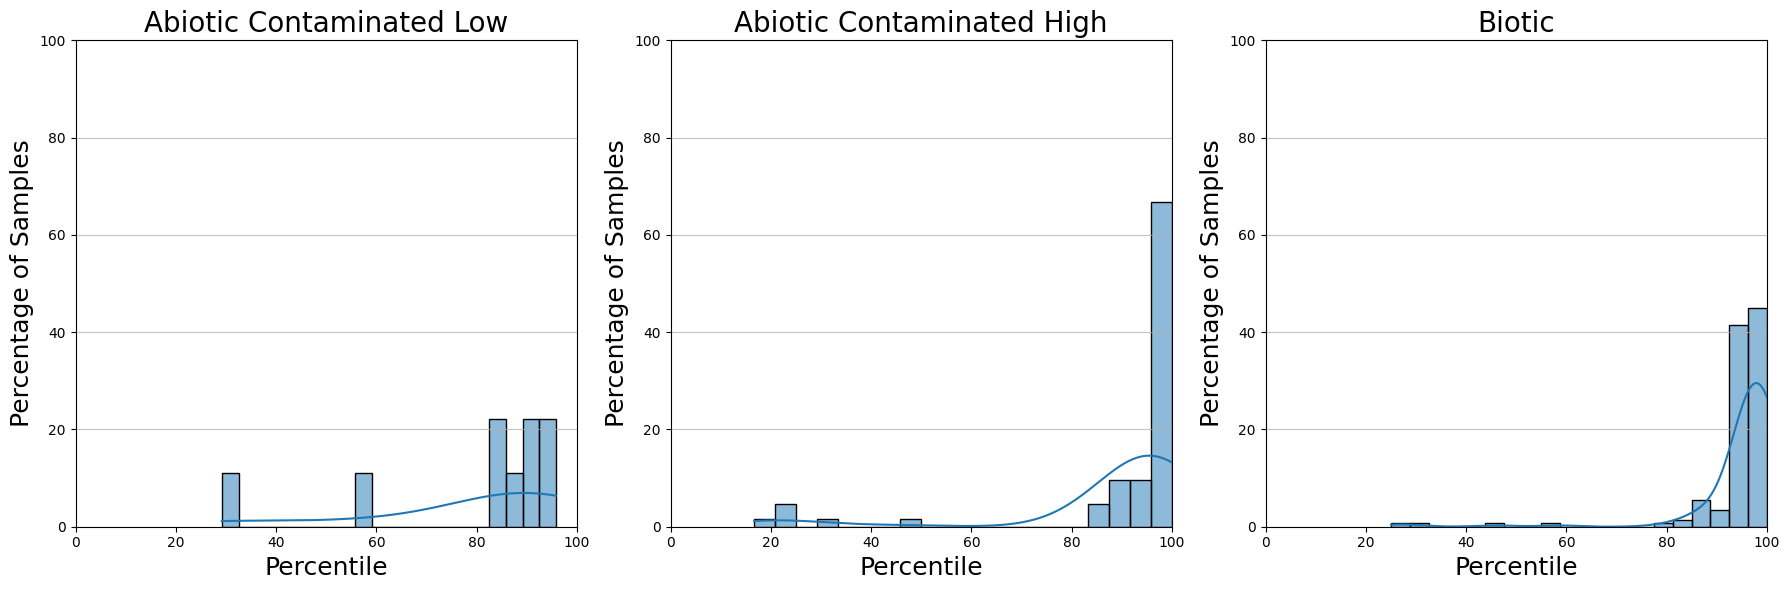

In [32]:
# Set up the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# First plot: AC_Low
AC_Low_df = pd.read_csv("AC_Low_anomalousness_results_6_amino.csv")
sns.histplot(
    data=AC_Low_df,
    x='Anomalousness Percentile of AC_Low Sample',
    kde=True,
    bins=20,
    stat="percent",
    ax=axs[0]
)
axs[0].set_title('Abiotic Contaminated Low', fontsize=20)
axs[0].set_xlabel('Percentile', fontsize=18)
axs[0].set_ylabel('Percentage of Samples', fontsize=18)
axs[0].set_ylim(0, 100)
axs[0].set_xlim(0,100)
axs[0].grid(axis='y', alpha=0.75)

# Second plot: AC_High
AC_High_df = pd.read_csv("AC_High_anomalousness_results_6_amino.csv")
sns.histplot(
    data=AC_High_df,
    x='Anomalousness Percentile of AC_High Sample',
    kde=True,
    bins=20,
    stat="percent",
    ax=axs[1]
)
axs[1].set_title('Abiotic Contaminated High', fontsize=20)
axs[1].set_xlabel('Percentile', fontsize=18)
axs[1].set_ylabel('Percentage of Samples', fontsize=18)
axs[1].set_ylim(0, 100)
axs[1].set_xlim(0,100)
axs[1].grid(axis='y', alpha=0.75)

# Third plot: Biotic
b_df = pd.read_csv("Biotic_anomalousness_results_6_amino.csv")
sns.histplot(
    data=b_df,
    x='Anomalousness Percentile of Biotic Sample',
    kde=True,
    bins=20,
    stat="percent",
    ax=axs[2]
)
axs[2].set_title('Biotic', fontsize=20)
axs[2].set_xlabel('Percentile', fontsize=18)
axs[2].set_ylabel('Percentage of Samples', fontsize=18)
axs[2].set_ylim(0, 100)
axs[2].set_xlim(0,100)
axs[2].grid(axis='y', alpha=0.75)

# Final layout
plt.tight_layout()
plt.savefig("anomalousness_percentile_comparison.png", dpi=300)
plt.show()

## Generate Figure 4

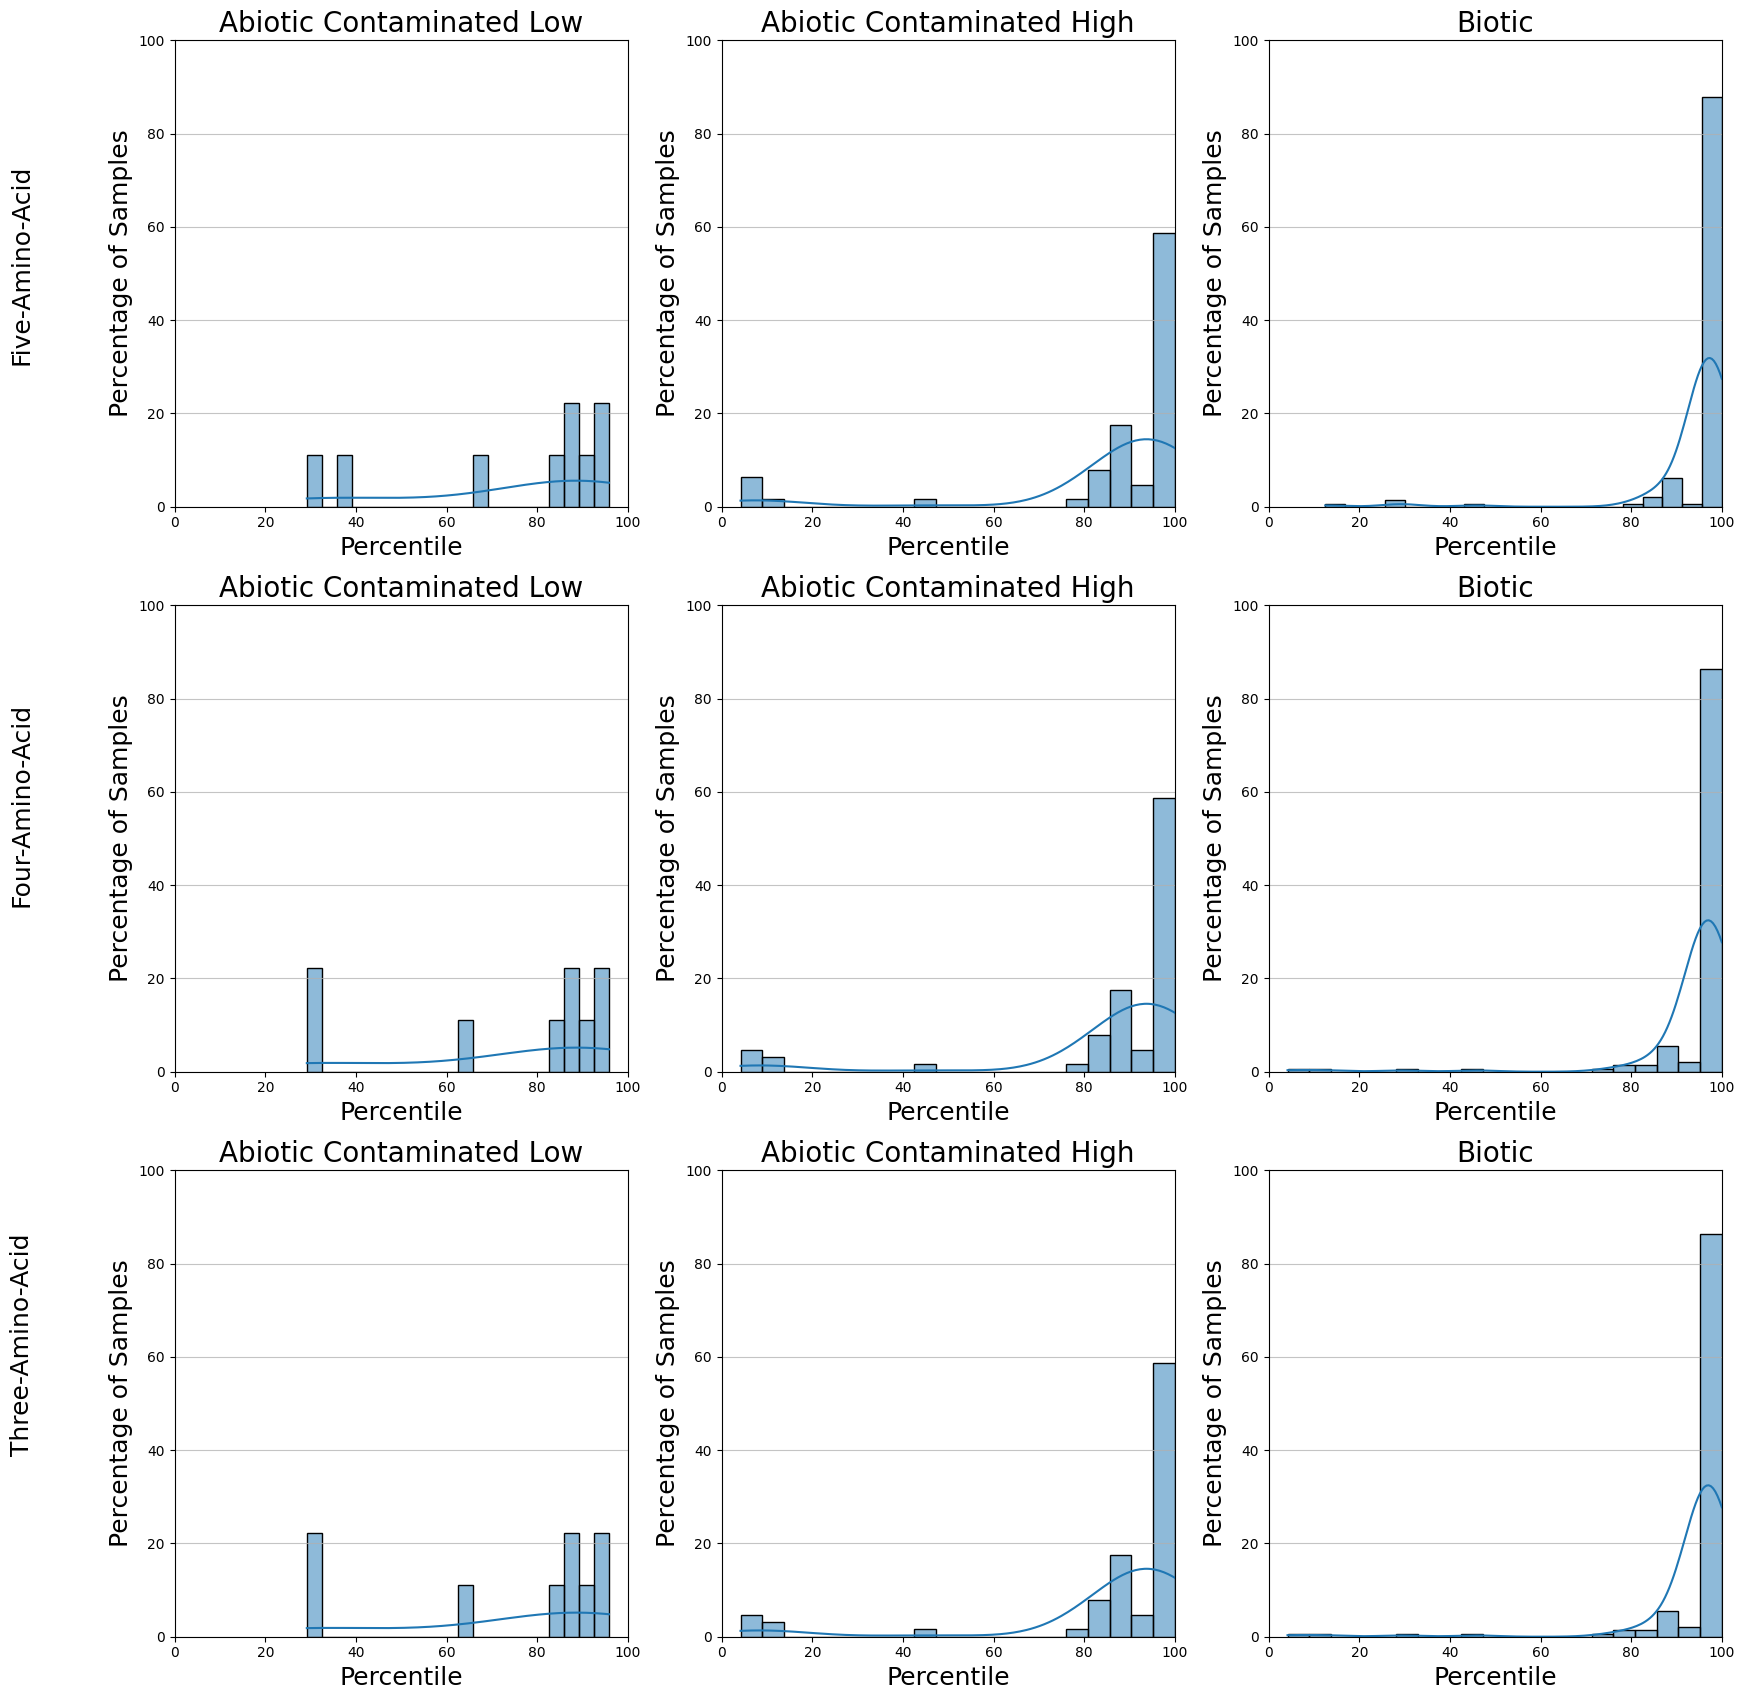

In [33]:
# Set up the figure and axes
fig, axs = plt.subplots(3, 3, figsize=(18, 18))

# First plot: AC_Low (Five-Amino-Acid)
AC_Low_df = pd.read_csv("AC_Low_anomalousness_results_5_amino.csv")
sns.histplot(data=AC_Low_df, x='Anomalousness Percentile of AC_Low Sample',
             stat='percent', kde=True, bins=20, ax=axs[0, 0])
axs[0, 0].set_title('Abiotic Contaminated Low',fontsize=20)
axs[0, 0].set_xlabel('Percentile',fontsize=18)
axs[0, 0].set_ylabel('Percentage of Samples',fontsize=18)
axs[0, 0].set_ylim(0, 100)
axs[0, 0].set_xlim(0, 100)
axs[0, 0].grid(axis='y', alpha=0.75)

# Second plot: AC_High (Five-Amino-Acid)
AC_High_df = pd.read_csv("AC_High_anomalousness_results_5_amino.csv")
sns.histplot(data=AC_High_df, x='Anomalousness Percentile of AC_High Sample',
             stat='percent', kde=True, bins=20, ax=axs[0, 1])
axs[0, 1].set_title('Abiotic Contaminated High',fontsize=20)
axs[0, 1].set_xlabel('Percentile',fontsize=18)
axs[0, 1].set_ylabel('Percentage of Samples',fontsize=18)
axs[0, 1].set_ylim(0, 100)
axs[0, 1].set_xlim(0, 100)
axs[0, 1].grid(axis='y', alpha=0.75)

# Third plot: Biotic (Five-Amino-Acid)
b_df = pd.read_csv("Biotic_anomalousness_results_5_amino.csv")
sns.histplot(data=b_df, x='Anomalousness Percentile of Biotic Sample',
             stat='percent', kde=True, bins=20, ax=axs[0, 2])
axs[0, 2].set_title('Biotic',fontsize=20)
axs[0, 2].set_xlabel('Percentile',fontsize=18)
axs[0, 2].set_ylabel('Percentage of Samples',fontsize=18)
axs[0, 2].set_ylim(0, 100)
axs[0, 2].set_xlim(0, 100)
axs[0, 2].grid(axis='y', alpha=0.75)


# First plot: AC_Low (Four-Amino-Acid)
AC_Low_df = pd.read_csv("AC_Low_anomalousness_results_3_amino.csv")
sns.histplot(data=AC_Low_df, x='Anomalousness Percentile of AC_Low Sample',
             stat='percent', kde=True, bins=20, ax=axs[1, 0])
axs[1, 0].set_title('Abiotic Contaminated Low',fontsize=20)
axs[1, 0].set_xlabel('Percentile',fontsize=18)
axs[1, 0].set_ylabel('Percentage of Samples',fontsize=18)
axs[1, 0].set_ylim(0, 100)
axs[1, 0].set_xlim(0, 100)
axs[1, 0].grid(axis='y', alpha=0.75)

# Second plot: AC_High (Four-Amino-Acid)
AC_High_df = pd.read_csv("AC_High_anomalousness_results_3_amino.csv")
sns.histplot(data=AC_High_df, x='Anomalousness Percentile of AC_High Sample',
             stat='percent', kde=True, bins=20, ax=axs[1, 1])
axs[1, 1].set_title('Abiotic Contaminated High',fontsize=20)
axs[1, 1].set_xlabel('Percentile',fontsize=18)
axs[1, 1].set_ylabel('Percentage of Samples',fontsize=18)
axs[1, 1].set_ylim(0, 100)
axs[1, 1].set_xlim(0, 100)
axs[1, 1].grid(axis='y', alpha=0.75)

# Third plot: Biotic (Four-Amino-Acid)
b_df = pd.read_csv("Biotic_anomalousness_results_3_amino.csv")
sns.histplot(data=b_df, x='Anomalousness Percentile of Biotic Sample',
             stat = 'percent', kde=True, bins=20, ax=axs[1, 2])
axs[1, 2].set_title('Biotic',fontsize=20)
axs[1, 2].set_xlabel('Percentile',fontsize=18)
axs[1, 2].set_ylabel('Percentage of Samples',fontsize=18)
axs[1, 2].set_ylim(0, 100)
axs[1, 2].set_xlim(0, 100)
axs[1, 2].grid(axis='y', alpha=0.75)


# First plot: AC_Low (Three-Amino-Acid)
AC_Low_df = pd.read_csv("AC_Low_anomalousness_results_3_amino.csv")
sns.histplot(data=AC_Low_df, x='Anomalousness Percentile of AC_Low Sample',
             stat='percent', kde=True, bins=20, ax=axs[2, 0])
axs[2, 0].set_title('Abiotic Contaminated Low',fontsize=20)
axs[2, 0].set_xlabel('Percentile',fontsize=18)
axs[2, 0].set_ylabel('Percentage of Samples',fontsize=18)
axs[2, 0].set_ylim(0, 100)
axs[2, 0].set_xlim(0, 100)
axs[2, 0].grid(axis='y', alpha=0.75)

# Second plot: AC_High (Three-Amino-Acid)
AC_High_df = pd.read_csv("AC_High_anomalousness_results_3_amino.csv")
sns.histplot(data=AC_High_df, x='Anomalousness Percentile of AC_High Sample',
             stat='percent', kde=True, bins=20, ax=axs[2, 1])
axs[2, 1].set_title('Abiotic Contaminated High',fontsize=20)
axs[2, 1].set_xlabel('Percentile',fontsize=18)
axs[2, 1].set_ylabel('Percentage of Samples',fontsize=18)
axs[2, 1].set_ylim(0, 100)
axs[2, 1].set_xlim(0, 100)
axs[2, 1].grid(axis='y', alpha=0.75)

# Third plot: Biotic (Three-Amino-Acid)
b_df = pd.read_csv("Biotic_anomalousness_results_3_amino.csv")
sns.histplot(data=b_df, x='Anomalousness Percentile of Biotic Sample',
             stat='percent', kde=True, bins=20, ax=axs[2, 2])
axs[2, 2].set_title('Biotic',fontsize=20)
axs[2, 2].set_xlabel('Percentile',fontsize=18)
axs[2, 2].set_ylabel('Percentage of Samples',fontsize=18)
axs[2, 2].set_ylim(0, 100)
axs[2, 2].set_xlim(0, 100)
axs[2, 2].grid(axis='y', alpha=0.75)

# Add row labels on the left
fig.text(0.04, 0.8, 'Five-Amino-Acid', va='center', ha='center',
                                  rotation='vertical', fontsize=18)
fig.text(0.04, 0.5, 'Four-Amino-Acid', va='center', ha='center',
                                  rotation='vertical', fontsize=18)
fig.text(0.04, 0.2, 'Three-Amino-Acid', va='center', ha='center',
                                  rotation='vertical', fontsize=18)

# Adjust layout
plt.tight_layout(rect=[0.08, 0, 1, 0.95])

plt.savefig("trunc_anomalousness_percentile_comparison.png", dpi=300)
plt.show()